In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import imageio
from pathlib import Path
import warnings

In [252]:
file_path = '/Volumes/KESU/IRCAM_data/jun282021/BBtarget/'
name = "30C.h5"

In [253]:
hf = h5py.File(file_path+name, 'r')
imgs = np.array(hf['imgs'])
ts  = np.array(hf['temps'])
ans = np.array(hf['set_angels'])
dark = np.array(hf['dark'])

for i in range(len(imgs)):
    imgs[i] = imgs[i] - dark[i]

imgs[imgs < 0] = np.mean(imgs)

S0 = np.sum(imgs,axis = 0)/2
S1 = imgs[0]-imgs[2]
S2 = imgs[1]-imgs[3]


s1 = S1/S0
s2 = S2/S0

DOLP = 100*np.sqrt(S1**2+S2**2)/S0
AOLP = 180/ (2*np.pi*np.arctan2 (S2,S1))

<ipython-input-253-f4539d490fc0>:21: RuntimeWarning: divide by zero encountered in true_divide
  AOLP = 180/ (2*np.pi*np.arctan2 (S2,S1))


In [254]:
vmx= np.median(S0[100:150,100:150])/1.5
np.mean(S0[140:150,140:150])/np.std(S0[140:150,140:150])

112.09550319166802

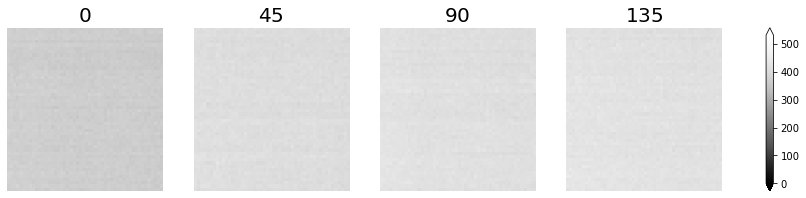

[30.6 30.6 30.6 30.6]


In [255]:
fig, axes = plt.subplots(figsize=(16, 3), ncols=4)



# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
pos1 = axes[0].imshow(np.transpose(imgs[0])[150:200,100:150], cmap='Greys_r', interpolation='none',vmin=0, vmax=vmx, aspect='auto')
#fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
axes[0].set_title("$0$",fontsize = 20)
axes[0].axis('off')
    
pos2 = axes[1].imshow(np.transpose(imgs[1])[150:200,100:150], cmap='Greys_r', interpolation='none',vmin=0, vmax=vmx, aspect='auto')
#fig.colorbar(pos2, ax=ax2,extend='both')
axes[1].set_title("$45$",fontsize = 20)
axes[1].axis('off')

pos3 = axes[2].imshow(np.transpose(imgs[2])[150:200,100:150], cmap='Greys_r', interpolation='none',vmin=0, vmax=vmx, aspect='auto')
#fig.colorbar(pos3, ax=ax3,extend='both')
axes[2].set_title("$90$",fontsize = 20)
axes[2].axis('off')

pos4 = axes[3].imshow(np.transpose(imgs[3])[150:200,100:150], cmap='Greys_r', interpolation='none',vmin=0, vmax=vmx, aspect='auto')
axes[3].set_title("$135$",fontsize = 20)
axes[3].axis('off')

fig.colorbar(pos1, ax=axes.ravel().tolist(), extend='both')

plt.show()

print(ts)

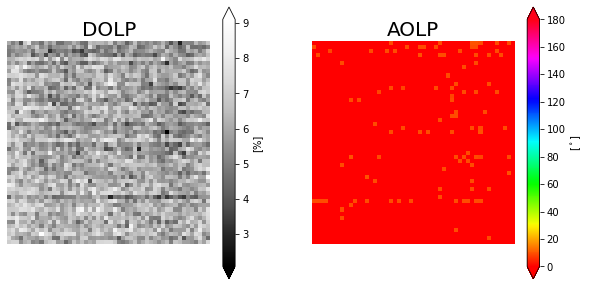

In [256]:
#set clim for S0 image
S0mean = np.mean(S0[100:150,150:200])
S0std  = np.std(S0[100:150,150:200])
dev = 4
    
s1m = np.max(np.abs(S1/S0))
s2m = np.max(np.abs(S2/S0)) 
    
#AOLP DOLP
fig, (ax2, ax3) = plt.subplots(figsize=(10, 5), ncols=2)
# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow


pos2 = ax2.imshow(np.transpose(DOLP)[150:200,100:150], cmap='Greys_r', interpolation='none')
fig.colorbar(pos2, ax=ax2,extend='both',label = '[%]')
ax2.set_title("DOLP",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow(np.transpose(AOLP)[150:200,100:150], cmap='hsv', interpolation='none',vmin=0, vmax=180)
fig.colorbar(pos3, ax=ax3,extend='both',label = "[$^\circ$]")
ax3.set_title("AOLP",fontsize = 20)
ax3.axis('off')
plt.show()
    

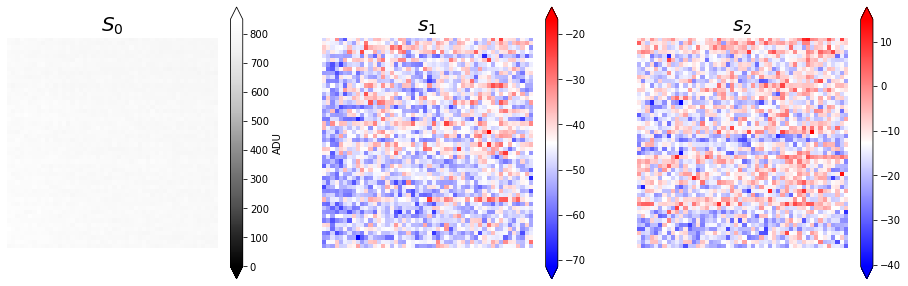

In [257]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 5), ncols=3)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
pos1 = ax1.imshow(np.transpose(S0)[150:200,100:150], cmap='Greys_r', interpolation='none',vmin=0, vmax= S0mean + dev*S0std)
fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
ax1.set_title("$S_0$",fontsize = 20)
ax1.axis('off')
    
pos2 = ax2.imshow(np.transpose(S1)[150:200,100:150], cmap='bwr', interpolation='none')
fig.colorbar(pos2, ax=ax2,extend='both')
ax2.set_title("$s_1$",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow(np.transpose(S2)[150:200,100:150], cmap='bwr', interpolation='none')
fig.colorbar(pos3, ax=ax3,extend='both')
ax3.set_title("$s_2$",fontsize = 20)
ax3.axis('off')


plt.show()

In [258]:
IMGS = []
S0s = []
S1s =[]
S2s = []
temps = (25,30,35,40,45,50,55,60,65,70);
for i in temps:
    name = str(i)+"C.h5"
    hf = h5py.File(file_path+name, 'r')
    imgs = np.array(hf['imgs'])
    ts  = np.array(hf['temps'])
    ans = np.array(hf['set_angels'])
    dark = np.array(hf['dark'])

    for i in range(len(imgs)):
        imgs[i] = imgs[i] - dark[i]

    imgs[imgs < 0] = np.mean(imgs)

    S0 = imgs[0]#np.sum(imgs,axis = 0)/2
    S1 = imgs[0]-imgs[2]
    S2 = imgs[1]-imgs[3]

    IMGS.append(imgs[100:150,150:200])
    S0s.append(S0[100:150,150:200])
    S1s.append(S1[100:150,150:200])
    S2s.append(S2[100:150,150:200])

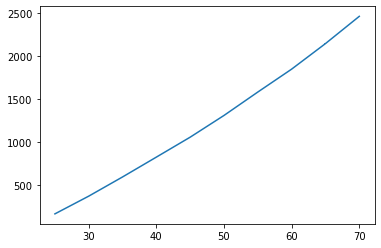

In [259]:
data = np.mean(np.mean(S0s,axis =1),axis = 1)
plt.errorbar(temps,data,yerr = np.std(np.std(S0s,axis =1),axis = 1))
plt.show()

In [200]:
def func(x, a, b):
    return a *  x + b

def func1(x, a, b,c):
    return a*(x-b)**c

In [203]:
popt1, pcov1 = curve_fit(func, temps, data)
popt2, pcov2 = curve_fit(func1, temps, data)

<ipython-input-200-40494a2a7daf>:5: RuntimeWarning: invalid value encountered in power
  return a*(x-b)**c


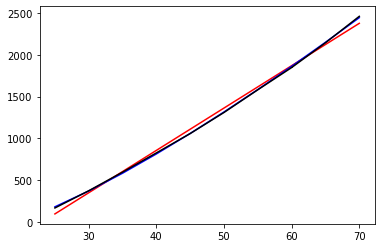

In [205]:
plt.plot(temps, func(np.double(temps), *popt1), 'r-')
plt.plot(temps, func1(np.double(temps), *popt2), 'b-')
plt.errorbar(temps,data,yerr = np.std(np.std(S0s,axis =1),axis = 1),color ='k')
plt.show()


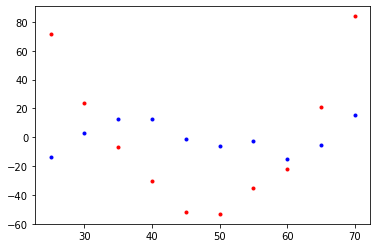

In [213]:
plt.plot(temps, data- func(np.double(temps), *popt1), 'r.')
plt.plot(temps, data-func1(np.double(temps), *popt2), 'b.')

In [214]:
def nrmse(data,fit):
    er = data -fit
    err = np.sqrt(np.mean(er**2))
    ymax = np.max(data)
    ymin = np.min(data)
    return err/(ymax-ymin)
